# Zennit implementation of lrp-tutorial

[Source](https://github.com/chr5tphr/zennit/issues/76#issuecomment-991009322)

## Christopher J. Anders' original implementation

In [1]:
import torch
from torch.nn import Conv2d, AvgPool2d
from torchvision.models import vgg16

from zennit.composites import NameMapComposite
from zennit.core import BasicHook, collect_leaves, stabilize
from zennit.rules import Gamma, Epsilon

# the LRP-Epsilon from the tutorial
class GMontavonEpsilon(BasicHook):
    def __init__(self, epsilon=1e-6, delta=0.25):
        super().__init__(
            input_modifiers=[lambda input: input],
            param_modifiers=[lambda param, _: param],
            output_modifiers=[lambda output: output],
            gradient_mapper=(lambda out_grad, outputs: out_grad / stabilize(outputs[0] + delta * (outputs[0] ** 2).mean() ** .5, epsilon)),
            reducer=(lambda inputs, gradients: inputs[0] * gradients[0])
        )

model = vgg16()

# only these get rules, linear layers will be attributed by the gradient alone
target_types = (Conv2d, AvgPool2d)
# lookup module -> name
child_name = {module: name for name, module in model.named_modules()}
# the layers in sequential order without any containers etc.
layers = list(enumerate(collect_leaves(model)))

# list of tuples [([names..], rule)] as used by NameMapComposite
name_map = [
    ([child_name[module] for n, module in layers if n <= 16 and isinstance(module, target_types)], Gamma(0.25)),
    ([child_name[module] for n, module in layers if 17 <= n <= 30 and isinstance(module, target_types)], GMontavonEpsilon(1e-9, 0.25)),
    ([child_name[module] for n, module in layers if 30 <= n and isinstance(module, target_types)], Epsilon(1e-9)),
]
# look at the name_map and you will see that there is no layer for which the last condition holds
print(name_map)

# create the composite from the name map
composite = NameMapComposite(name_map)

with composite.context(model) as modified_model:
    # compute attribution
    data = torch.randn(1, 3, 224, 224, requires_grad=True)
    output = modified_model(data)
    output.backward(torch.eye(1000)[[0]])
    # print absolute sum of attribution
    print(data.grad.abs().sum().item())

[(['features.0', 'features.2', 'features.5', 'features.7', 'features.10', 'features.12', 'features.14'], <zennit.rules.Gamma object at 0x110eb4070>), (['features.17', 'features.19', 'features.21', 'features.24', 'features.26', 'features.28'], <__main__.GMontavonEpsilon object at 0x11922f400>), ([], <zennit.rules.Epsilon object at 0x11922f4c0>)]
2.6483840942382812


### With heatmap

[(['features.0', 'features.2', 'features.5', 'features.7', 'features.10', 'features.12', 'features.14'], <zennit.rules.Gamma object at 0x110eb6460>), (['features.17', 'features.19', 'features.21', 'features.24', 'features.26', 'features.28'], <__main__.GMontavonEpsilon object at 0x110eb4310>), ([], <zennit.rules.Epsilon object at 0x126b454f0>)]
9.954010009765625


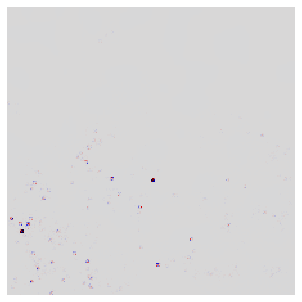

In [6]:
import torch
from torch.nn import Conv2d, AvgPool2d
from torchvision.models import vgg16

from zennit.composites import NameMapComposite
from zennit.core import BasicHook, collect_leaves, stabilize
from zennit.rules import Gamma, Epsilon

import cv2
import numpy
import utils

# the LRP-Epsilon from the tutorial
class GMontavonEpsilon(BasicHook):
    def __init__(self, epsilon=1e-6, delta=0.25):
        super().__init__(
            input_modifiers=[lambda input: input],
            param_modifiers=[lambda param, _: param],
            output_modifiers=[lambda output: output],
            gradient_mapper=(lambda out_grad, outputs: out_grad / stabilize(outputs[0] + delta * (outputs[0] ** 2).mean() ** .5, epsilon)),
            reducer=(lambda inputs, gradients: inputs[0] * gradients[0])
        )

model = vgg16()

class BatchNormalize:
    def __init__(self, mean, std, device=None):
        self.mean = torch.tensor(mean, device=device)[None, :, None, None]
        self.std = torch.tensor(std, device=device)[None, :, None, None]

    def __call__(self, tensor):
        return (tensor - self.mean) / self.std


# mean and std of ILSVRC2012 as computed for the torchvision models
norm_fn = BatchNormalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225), device='cpu')

# only these get rules, linear layers will be attributed by the gradient alone
target_types = (Conv2d, AvgPool2d)
# lookup module -> name
child_name = {module: name for name, module in model.named_modules()}
# the layers in sequential order without any containers etc.
layers = list(enumerate(collect_leaves(model)))

# list of tuples [([names..], rule)] as used by NameMapComposite
name_map = [
    ([child_name[module] for n, module in layers if n <= 16 and isinstance(module, target_types)], Gamma(0.25)),
    ([child_name[module] for n, module in layers if 17 <= n <= 30 and isinstance(module, target_types)], GMontavonEpsilon(1e-9, 0.25)),
    ([child_name[module] for n, module in layers if 30 <= n and isinstance(module, target_types)], Epsilon(1e-9)),
]
# look at the name_map and you will see that there is no layer for which the last condition holds
print(name_map)

# create the composite from the name map
composite = NameMapComposite(name_map)

with composite.context(model) as modified_model:
    # compute attribution
    # Returns a numpy array in BGR color space, not RGB
    img = cv2.imread('castle.jpg')

    # Convert from BGR to RGB color space
    img = img[..., ::-1]

    # img.shape is (224, 224, 3), where 3 corresponds to RGB channels
    # Divide by 255 (max. RGB value) to normalize pixel values to [0,1]
    img = img/255.0
    
    data = norm_fn(
        torch.FloatTensor(
            img[numpy.newaxis].transpose([0, 3, 1, 2])*1
        )
    )
    data.requires_grad = True

    output = modified_model(data)
    output[0].max().backward()

    # print absolute sum of attribution
    print(data.grad.abs().sum().item())

    R = data.grad

    utils.heatmap(R[0].sum(dim=0).detach().numpy(), 4,4)

## Rodrigo's implementation

[(['features.0'], <zennit.rules.ZBox at 0x110ebba60>),
 (['features.2',
   'features.5',
   'features.7',
   'features.10',
   'features.12',
   'features.14'],
  <zennit.rules.Gamma at 0x110e52940>),
 (['features.17',
   'features.19',
   'features.21',
   'features.24',
   'features.26',
   'features.28'],
  <__main__.GMontavonEpsilon at 0x110e52910>),
 (['classifier.0', 'classifier.3', 'classifier.6'],
  <zennit.rules.Epsilon at 0x126b45670>)]

0.24230265617370605


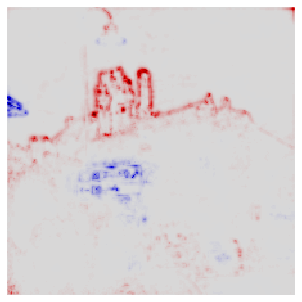

In [3]:
import torch
from torch.nn import Conv2d, AvgPool2d, Linear
from torchvision.models import vgg16

from zennit.composites import NameMapComposite
from zennit.core import BasicHook, collect_leaves, stabilize
from zennit.rules import Gamma, Epsilon, ZBox

import cv2
import numpy
import utils

# the LRP-Epsilon from the tutorial
class GMontavonEpsilon(BasicHook):
    def __init__(self, stabilize_epsilon=1e-6, epsilon=0.25):
        super().__init__(
            input_modifiers=[lambda input: input],
            param_modifiers=[lambda param, _: param],
            output_modifiers=[lambda output: output],
            gradient_mapper=(lambda out_grad, outputs: out_grad / stabilize(
                outputs[0] + epsilon * (outputs[0] ** 2).mean() ** .5, stabilize_epsilon)),
            reducer=(lambda inputs, gradients: inputs[0] * gradients[0])
        )

# use the gpu if requested and available, else use the cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class BatchNormalize:
    def __init__(self, mean, std, device=None):
        self.mean = torch.tensor(mean, device=device)[None, :, None, None]
        self.std = torch.tensor(std, device=device)[None, :, None, None]

    def __call__(self, tensor):
        return (tensor - self.mean) / self.std


# mean and std of ILSVRC2012 as computed for the torchvision models
norm_fn = BatchNormalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225), device=device)
batch_size = 1
# the maximal input shape, needed for the ZBox rule
shape = (batch_size, 3, 224, 224)

# the highest and lowest pixel values for the ZBox rule
low = norm_fn(torch.zeros(*shape, device=device))
high = norm_fn(torch.ones(*shape, device=device))


model = vgg16(pretrained=True)
model.eval()

# only these get rules, linear layers will be attributed by the gradient alone
# target_types = (Conv2d, AvgPool2d)
target_types = (Conv2d, AvgPool2d, Linear)
# lookup module -> name
child_name = {module: name for name, module in model.named_modules()}
# the layers in sequential order without any containers etc.
layers = list(enumerate(collect_leaves(model)))

# list of tuples [([names..], rule)] as used by NameMapComposite
name_map = [
    ([child_name[module] for n, module in layers if n == 0 and isinstance(module, target_types)], ZBox(low=low, high=high)),
    ([child_name[module] for n, module in layers if 1 <= n <= 16 and isinstance(module, target_types)], Gamma(0.25)),
    ([child_name[module] for n, module in layers if 17 <= n <= 30 and isinstance(module, target_types)], GMontavonEpsilon(stabilize_epsilon=0, epsilon=0.25)),
    ([child_name[module] for n, module in layers if 31 <= n and isinstance(module, target_types)], Epsilon(0)),
]

# look at the name_map and you will see that there is no layer for which the last condition holds
display(name_map)

# create the composite from the name map
composite = NameMapComposite(name_map)

R = None
with composite.context(model) as modified_model:
    # compute attribution
    # Returns a numpy array in BGR color space, not RGB
    img = cv2.imread('castle.jpg')

    # Convert from BGR to RGB color space
    img = img[..., ::-1]

    # img.shape is (224, 224, 3), where 3 corresponds to RGB channels
    # Divide by 255 (max. RGB value) to normalize pixel values to [0,1]
    img = img/255.0
    
    data = norm_fn(
        torch.FloatTensor(
            img[numpy.newaxis].transpose([0, 3, 1, 2])*1
        )
    )
    data.requires_grad = True

    output = modified_model(data)
    output[0].max().backward()

    # print absolute sum of attribution
    print(data.grad.abs().sum().item())

    R = data.grad

    utils.heatmap(R[0].sum(dim=0).detach().numpy(), 4,4)


In [4]:
print(*list(zip(*layers))[1], sep='\n')
for n, module in layers:
  print(f'{n} {child_name[module]}')

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

## Zennit's heatmapping function

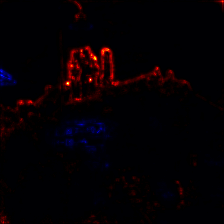

In [5]:
from zennit.image import imgify


# sum over the color channels
heatmap = R.sum(dim=1)
# get the absolute maximum, to center the heat map around 0
amax = heatmap.abs().detach().numpy().max((1, 2))

# save heat map with color map 'coldnhot'
imgify(
    heatmap[0].detach().numpy(),
    vmin=-amax,
    vmax=amax,
    cmap='coldnhot',
    level=1.0
)